# README

본 실습 자료는 세 가지 종류의 cell로 구성되어 있습니다.

- [Job]: 실습을 위해 직접 조작해야 하는 부분


- [Option]: 실습을 위해 필수적으로 조작할 필요는 없으나 이해하기 쉬운 부분


- [Skeleton code]: 실습을 돕기 위한 백그라운드, 동작 원리를 100% 이해할 필요없음

앞으로 천문학을 더 깊게 공부하고 연구하게 될 분들께 [Skeleton code]를 바칩니다.

작성자: Seungwu Yoo

### Import Modules

필요한 모듈 목록

- numpy
- matplotlib
- pandas
- astroquery
- astropy
- reproject
- sklearn

하단의 cell에서 ModuleNotFoundError가 뜬다면, 해당 모듈을 실행하고 있는 커널의 가상환경에 설치하셔야 합니다. 
- 설치 방법 (가상환경 접속 후): conda install [module name]
- 안 될 경우: pip install [module name]
- 될 경우: 터미널 메시지 확인 후 Proceed ([y]/n)? 이 뜨면 y를 입력하고 엔터를 누르시면 됩니다. 

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import astropy as ap
import astroquery as aq
import reproject as rp
import sklearn as sk
from astroquery.simbad import Simbad
from astroquery.sdss import SDSS
from astropy import units as u
from astropy.table import vstack
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from sklearn.linear_model import LinearRegression

print(f'numpy ver:          {np.__version__}')
print(f'matplotlpib ver:    {mp.__version__}')
print(f'pandas ver:         {pd.__version__}')
print(f'astropy ver:        {ap.__version__}')
print(f'astroquery ver:      {aq.__version__}')
print(f'reproject ver: {rp.__version__}')
print(f'sklearn ver: {sk.__version__}')

numpy: 1.26.4
matplotlpib: 3.8.4
pandas: 2.2.2
astropy: 6.1.0
astroquery: 0.4.7
reproject: 0.14.0
sklearn: 1.5.1


### [Option] Adjust rcParams

원하시는 figure 세팅이 있으시면, 해당 cell을 직접 조작하시면 됩니다.

[참고] rcParams이란? 
- runtime configurations parameters, 줄여서 rcparams

- matplotlib을 이용할 때, 원하는 figure의 스타일 (예: 폰트, 축의 두께 등)을 default로 입력하는 하나의 방식이다.

- 한 번 rcparam을 세팅해두면, 커널 (ipynb 파일 하나)를 재실행하기 전까지는 해당 설정이 유지된다.

- 물론 rcparam을 세팅하지 않고 그래프를 그리는 함수를 쓸 때 원하는 설정값을 직접 입력하는 방법도 있다. 

- 그래프를 그리는 함수에서 원하는 세팅을 입력할 경우, 그 세팅이 우선된다.

- 참조: https://matplotlib.org/stable/users/explain/customizing.html#customizing-with-dynamic-rc-settings

- rcparam ref: Taewan Kim

In [25]:
plt.rcParams["font.family"] = 'STIXGeneral'
plt.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams["axes.labelweight"] = "bold"

plt.rcParams.update({'font.size': 60})
plt.rcParams.update({'font.weight': 'normal'})

plt.rcParams.update({'xtick.direction': 'in'})
plt.rcParams.update({'ytick.direction': 'in'})
plt.rcParams.update({'xtick.major.size': 20})
plt.rcParams.update({'xtick.minor.size': 12})
plt.rcParams.update({'ytick.major.size': 20})
plt.rcParams.update({'ytick.minor.size': 12})
plt.rcParams.update({'xtick.major.width': 2})
plt.rcParams.update({'xtick.minor.width': 2})
plt.rcParams.update({'ytick.major.width': 2})
plt.rcParams.update({'ytick.minor.width': 2})
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'axes.linewidth': 8})
plt.rcParams.update({'axes.labelpad': 8})
plt.rcParams.update({'xtick.major.pad': 20})
plt.rcParams.update({'ytick.major.pad': 12})
plt.rcParams.update({'image.origin':'lower'})
plt.rcParams.update({"axes.grid" : True, "grid.color": "black"})

### [Skeleton code] Various functions to query objects from VizieR, SIMBAD, SDSS

- VizieR: CDS에서 운영하는 논문 catalog 관리 시스템 (링크: https://vizier.unistra.fr/)

- SIMBAD: CDS에서 운영하는 태양계 외부 천체 데이터베이스 (링크: https://simbad.cds.unistra.fr/simbad/)

- SDSS: Sloan Digital Sky Survey: (링크: https://www.sdss.org/)

In [26]:
def format_coord(coord_str, sep, type_split=':'):
    parts = coord_str.split(type_split)
    return f'{parts[0]}{sep[0]}{parts[1]}{sep[1]}{parts[2]}{sep[2]}'

def vizier_query(name, catalog='II/183A/table2'):
    ra, dec = Simbad.query_object(name)['RA','DEC'][0]
    coords = SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))

    columns = ['*']
    v = Vizier(columns=columns)
    query = v.query_region(coords, catalog=catalog, width=1 * u.deg, height=1 * u.deg)[0].to_pandas()
    print(f'number of rows = {len(query)}')
    return query

def simbad_crossID(name, region_rad=2):
    result_table = Simbad.query_object(name)
    ra, dec = format_coord(result_table['RA'][0], sep=['h', 'm', 's'],type_split=' '), \
            format_coord(result_table['DEC'][0], sep=['d', 'm', 's'],type_split=' ')
    pos = SkyCoord(ra, dec, frame='icrs')
    xid = SDSS.query_crossid(pos, radius='0.5 arcsec', \
        photoobj_fields=['objid', 'ra', 'dec', \
            'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z',\
            'modelMagerr_u', 'modelMagerr_g', 'modelMagerr_r', 'modelMagerr_i', 'modelMagerr_z'])
    ra_deg, dec_deg = pos.ra.deg, pos.dec.deg
    query = f'''
            SELECT TOP 100 objid, ra, dec, flags, 
                (POWER(ra - {ra_deg}, 2) + POWER(dec - {dec_deg}, 2)) AS distance
            FROM PhotoObj
            WHERE flags & dbo.fPhotoFlags('SATURATED') > 0
                AND ra BETWEEN {ra_deg - region_rad} AND {ra_deg + region_rad}
                AND dec BETWEEN {dec_deg - region_rad} AND {dec_deg + region_rad}
            ORDER BY distance ASC
            '''
    query_result = SDSS.query_sql(query)
    query_id = query_result['objid']
    
    results = SDSS.query_region(pos, radius=region_rad*u.arcmin)
    try:
        target = results[(results['objid'] == xid['objid'])]            
        run, camcol, field = target['run'][0], target['camcol'][0], target['field'][0]
        if np.sum(query_id == xid['objid']) == 0:
            return xid, (run, camcol, field), True
        else:
            return xid, (run, camcol, field), False
    except TypeError:
        return xid, False, None

### [Job] Select field of Landolt standard stars

field_name 변수에 원하시는 field를 입력하여 query (검색) 대상 변경 가능


가능한 field 목록

- sa92
- sa98
- sa101
- sa104

In [27]:
field_name = 'sa92'

landolt = vizier_query(field_name, catalog='II/183A/table2')
landolt.head(5)

number of rows = 46


RAJ2000    DEJ2000    Vmag  e_Vmag    B-V   e_B-V    U-B   e_U-B    V-R  \
0  06 51 27  -00 15 37  13.089  0.0021  1.283  0.0007  1.003  0.0014  0.701   
1  06 51 29  -00 16 27  14.001  0.0035  0.469  0.0014  0.357  0.0021  0.283   
2  06 51 30  -00 24 52  14.137  0.0053  0.338  0.0053  0.126  0.0131  0.196   
3  06 51 30  -00 25 07  14.780  0.0007  1.397  0.0544  1.072  0.0269  0.755   
4  06 51 31  -00 18 59  12.185  0.0028  0.522  0.0049 -0.002  0.0035  0.305   

    e_V-R    R-I   e_R-I    V-I   e_V-I SimbadName  
0  0.0021  0.662  0.0000  1.362  0.0021  SA 98 961  
1  0.0014  0.331  0.0191  0.613  0.0205  SA 98 966  
2  0.0057  0.243  0.0045  0.437  0.0090  SA 98 556  
3  0.0092  0.741  0.0297  1.494  0.0198  SA 98 557  
4  0.0014  0.303  0.0014  0.607  0.0000  SA 98 562

### [Skeleton Code] Cross match landolt field with SDSS

In [28]:
SDSS_table, imgs_meta, flag_sat = [], [], []
for name in landolt['SimbadName']:
    xid, fields, non_sat = simbad_crossID(name, region_rad=2)
    if xid is None:
        print(f'Simbad.query_object can\'t detect {name}')
    else:
        xid['Simbadname'] = name
        SDSS_table.append(xid)
    if not fields:
        print(f'SDSS.query_region can\'t detect {name}')
    else:
        imgs_meta.append(fields)
        if not non_sat:
            print(f'Caution: {name} is saturated')
        flag_sat.append(non_sat)
imgs_meta = list(set(imgs_meta))
SDSS_table = vstack(SDSS_table)
print(SDSS_table.keys())

Caution: SA 98 961 is saturated
Caution: SA 98 966 is saturated
Caution: SA 98 562 is saturated
Simbad.query_object can't detect SA 98 978
SDSS.query_region can't detect SA 98 978
Caution: [L92b] SA 98 L3 is saturated
Caution: SA 98 618 is saturated
Caution: SA 98 624 is saturated
Caution: SA 98 626 is saturated
Simbad.query_object can't detect SA 98 185
SDSS.query_region can't detect SA 98 185
Caution: SA 98 193 is saturated
Simbad.query_object can't detect SA 98 653
SDSS.query_region can't detect SA 98 653
Caution: SA 98 650 is saturated
Caution: SA 98 666 is saturated
Caution: SA 98 671 is saturated
Caution: SA 98 670 is saturated
Caution: SA 98 676 is saturated
Caution: SA 98 675 is saturated
Caution: [L92b] SA 98 L5 is saturated
Caution: SA 98 682 is saturated
Simbad.query_object can't detect SA 98 685
SDSS.query_region can't detect SA 98 685
Caution: SA 98 688 is saturated
Simbad.query_object can't detect SA 98 1082
SDSS.query_region can't detect SA 98 1082
Caution: SA 98 1087 is

### [Skeleton Code] Make mosaic image

In [29]:
def get_hdus(imgs_meta):
    image_hdus = []
    for img_meta in imgs_meta:
        run, camcol, field = img_meta
        image_hdu = SDSS.get_images(run=run, camcol=camcol, field=field)[0]
        image_hdus.append(image_hdu[0])
    return image_hdus

image_hdus = get_hdus(imgs_meta)
wcs_out, shape_out = find_optimal_celestial_wcs(image_hdus)

array, footprint = reproject_and_coadd(image_hdus,
                                       wcs_out, shape_out=shape_out,
                                       reproject_function=reproject_interp)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '23/11/98' to '1998-11-23''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '23/11/98' to '1998-11-23''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '23/11/98' to '1998-11-23''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '23/11/98' to '1998-11-23''. [astropy.wcs.wcs]


### [Skeleton Code] Plot mosaic image

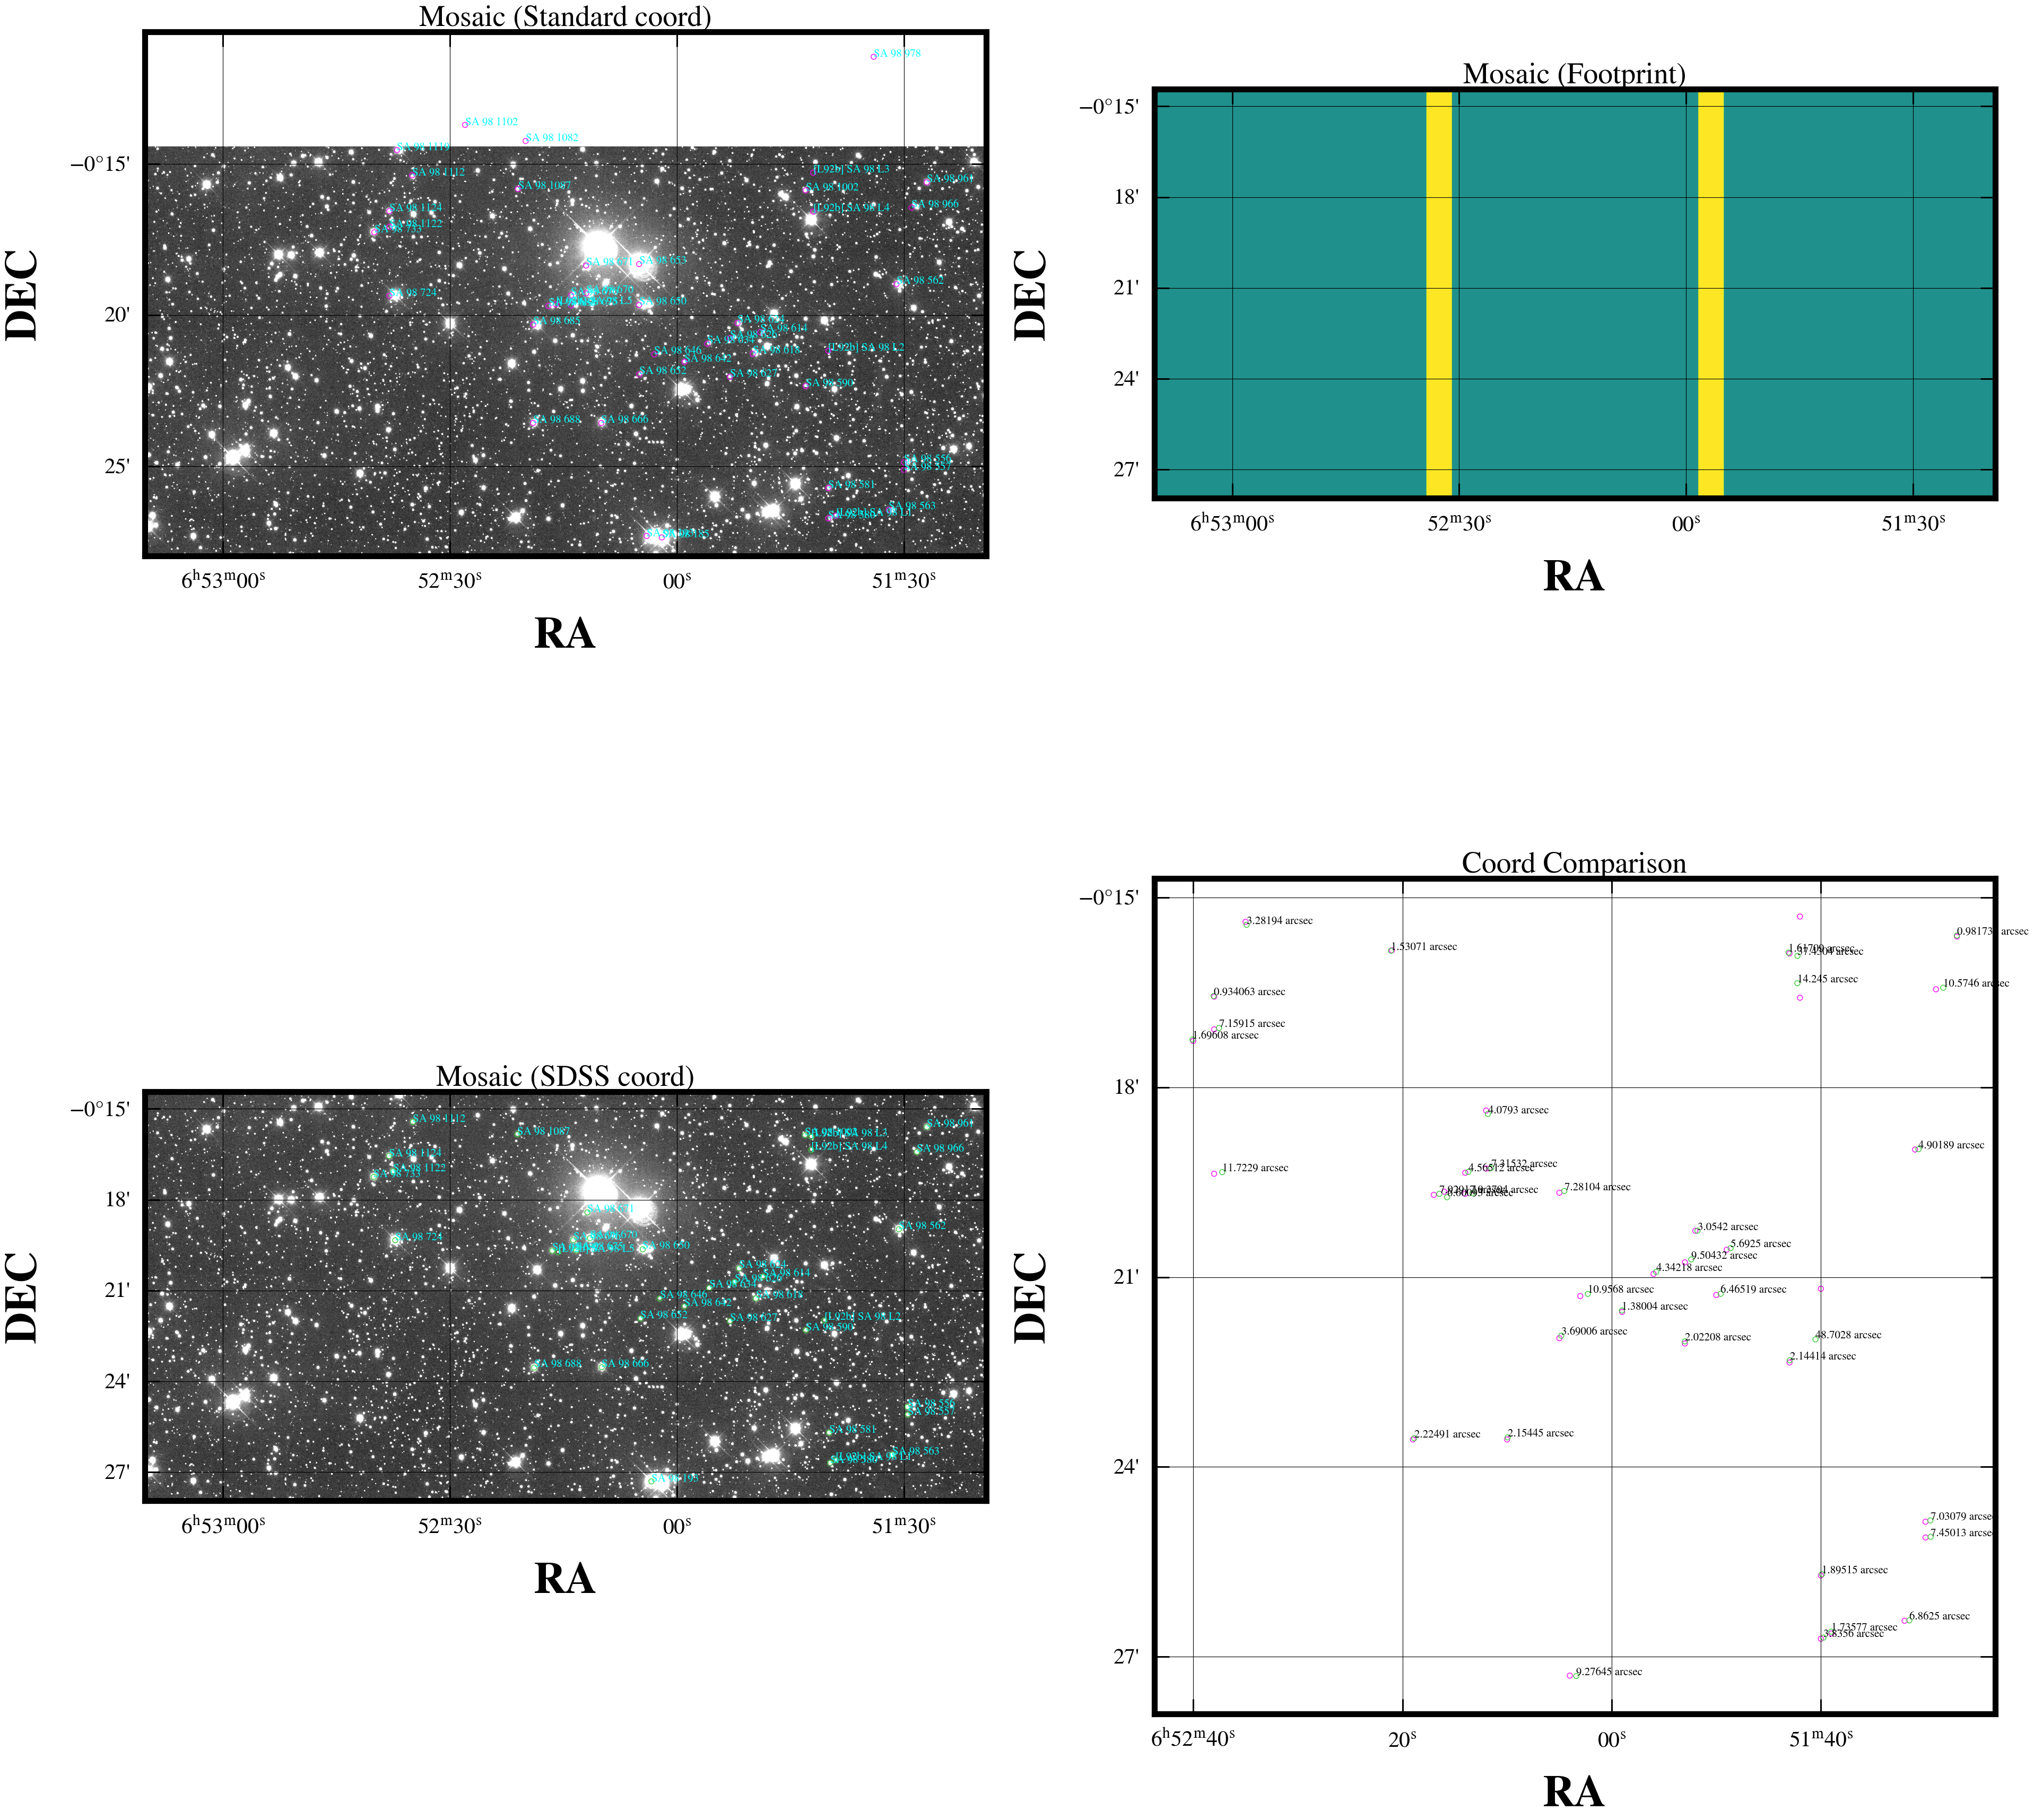

In [30]:
plt.figure(figsize=(45, 45))
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

norm = ImageNormalize(array, interval=ZScaleInterval())
ax1 = plt.subplot(2, 2, 1, projection=wcs_out)
im1 = ax1.imshow(array, origin='lower', norm=norm, cmap='gray')
ax1.set_title('Mosaic (Standard coord)', fontsize=40)

ax2 = plt.subplot(2, 2, 3, projection=wcs_out)
im2 = ax2.imshow(array, origin='lower', norm=norm, cmap='gray')
ax2.set_title('Mosaic (SDSS coord)', fontsize=40)

ax4 = plt.subplot(2, 2, 4, projection=wcs_out)
ax4.set_title('Coord Comparison', fontsize=40)

separation = {}

for i in range(len(landolt)):
    ra, dec = landolt['RAJ2000'][i], landolt['DEJ2000'][i]
    ra_dec1 = SkyCoord(ra=format_coord(ra, ['h', 'm', 's'], type_split=' '), \
                    dec=format_coord(dec, ['d', 'm', 's'], type_split=' '), frame='icrs')
    x, y = wcs_out.world_to_pixel(ra_dec1)
    ax1.scatter(x, y, facecolor='none', edgecolor='magenta', s=50)
    name = landolt['SimbadName'][i]
    ax1.text(x, y + 3, name, color='cyan', fontsize=15)
    SDSS_i = np.where(np.array(SDSS_table['Simbadname']) == name)[0]
    if len(SDSS_i) == 1:
        ax4.scatter(x, y, facecolor='none', edgecolor='magenta', s=50)
        ra, dec = SDSS_table['ra'][SDSS_i], SDSS_table['dec'][SDSS_i]
        ra_dec2 = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
        x, y = wcs_out.world_to_pixel(ra_dec2)
        angle = ra_dec1.separation(ra_dec2)
        angle_sec = angle.to(u.arcsecond)[0]
        separation[name] = angle_sec
        ax2.scatter(x, y, facecolor='none', edgecolor='limegreen', s=50)
        ax2.text(x, y + 3, name, color='cyan', fontsize=15)
        ax4.scatter(x, y, facecolor='none', edgecolor='limegreen', s=50)
        ax4.text(x, y + 3, angle_sec, color='black', fontsize=15)
    
ax3 = plt.subplot(2, 2, 2, projection=wcs_out)
im3 = ax3.imshow(footprint, origin='lower')
ax3.set_title('Mosaic (Footprint)', fontsize=40)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('RA', fontsize=60)
    ax.set_ylabel('DEC', fontsize=60)
    
plt.savefig(f'{field_name}_mosaic.png')

### [Skeleton Code] Make field table

In [ ]:
SDSS_keys = ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 
             'modelMagerr_u', 'modelMagerr_g', 'modelMagerr_r', 'modelMagerr_i', 'modelMagerr_z']
landolt_keys = ['Vmag', 'e_Vmag', 'B-V', 'e_B-V', 'U-B', 'e_U-B',
                'V-R', 'e_V-R', 'R-I', 'e_R-I', 'V-I', 'e_V-I']

landolt_id, sep_list = [], []
field_dict = {}
for name in SDSS_table['Simbadname']:
    sep_list.append(separation[name])
    landolt_id.append(np.where(landolt['SimbadName'] == name)[0][0])

field_dict['SimbadName'] = list(SDSS_table['Simbadname'])
field_dict['separation'] = sep_list
field_dict['non_saturated'] = list(flag_sat)

for key in SDSS_keys:
    field_dict[key] = list(SDSS_table[key])
for key in landolt_keys:
    field_dict[key] = list(landolt[key][landolt_id])
    
field_table = pd.DataFrame(data = field_dict)
field_table.to_csv(f'{field_name}.csv')
field_table.head(5)

### [Option] Functions for linear regression and plot

Sckit learn의 LinearRegression method를 활용하여 피팅
- 참조: https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html
- Linear Regression을 수행할 수 있는 다른 방법을 사용해도 무방 (예: scipy.optimize.curve_fit 등)

In [31]:
def plot_maker(mag_y_1, band_y_1, err_y_1, mag_y_2, band_y_2, err_y_2, 
               mag_x_1, band_x_1, err_x_1, mag_x_2, band_x_2, err_x_2, 
               non_sat, sep_arr, sep_lim, show_saturation=False):
    
    arr_y, arr_x, arr_yerr, arr_xerr = [], [], [], []
    sat_y, sat_x, sat_yerr, sat_xerr = [], [], [], []
    
    for i in range(len(non_sat)):
        if sep_arr[i] < sep_lim and non_sat[i]:
            arr_y.append(mag_y_1[i] - mag_y_2[i])
            arr_yerr.append(np.sqrt(err_y_1[i] ** 2 + err_y_2[i] ** 2))
            arr_x.append(mag_x_1[i] - mag_x_2[i])
            arr_xerr.append(np.sqrt(err_x_1[i] ** 2 + err_x_2[i] ** 2))
        elif sep_arr[i] < sep_lim:
            sat_y.append(mag_y_1[i] - mag_y_2[i])
            sat_yerr.append(np.sqrt(err_y_1[i] ** 2 + err_y_2[i] ** 2))
            sat_x.append(mag_x_1[i] - mag_x_2[i])
            sat_xerr.append(np.sqrt(err_x_1[i] ** 2 + err_x_2[i] ** 2))

    arr_y, arr_x, arr_yerr, arr_xerr = np.array(arr_y), np.array(arr_x), np.array(arr_yerr), np.array(arr_xerr)
            
    model = LinearRegression()
    model.fit(X=arr_x.reshape(-1, 1) , y=arr_y)
    X = np.linspace(min(arr_x), max(arr_x), 100)
    pred = model.predict(X.reshape(-1, 1))

    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(arr_x, arr_y, s=4, color='black')
    ax.errorbar(arr_x, arr_y, xerr=arr_xerr, yerr=arr_yerr, linestyle='none', capsize=2, color='black')
    if show_saturation:
        ax.scatter(sat_x, sat_y, s=4, color='black')
        ax.errorbar(sat_x, sat_y, xerr=sat_xerr, yerr=sat_yerr, linestyle='none', capsize=2, color='blue')
    ax.plot(X, pred, color='red', linestyle='--')

    Z, k = model.intercept_, model.coef_[0]
    Rsq = model.score(arr_x.reshape(-1, 1), arr_y)
    
    ax.set_ylabel(f'{band_y_1} - {band_y_2}', fontsize=40)
    ax.set_xlabel(f'{band_x_1} - {band_x_2}', fontsize=40)
    ax.set_title(f'$k$ = {round(k, 3)}, $Z$ = {round(Z, 3)}, $R^2$ = {round(Rsq, 4)}', fontsize=60)

### [Job] Standard Calibration!

- y축 band 1과 band 2, x축 band 1과 band 2를 직접 조정해볼 수 있음
- mag 변수는 field_table에서 원하는 band에 해당하는 column을 선택하여 입력
- band 변수는, 해당 column이 나타내는 band가 무엇인지 str(문자)으로 입력
- err 변수는, field_table에서 원하는 band의 error값에 해당하는 column을 선택하여 입력

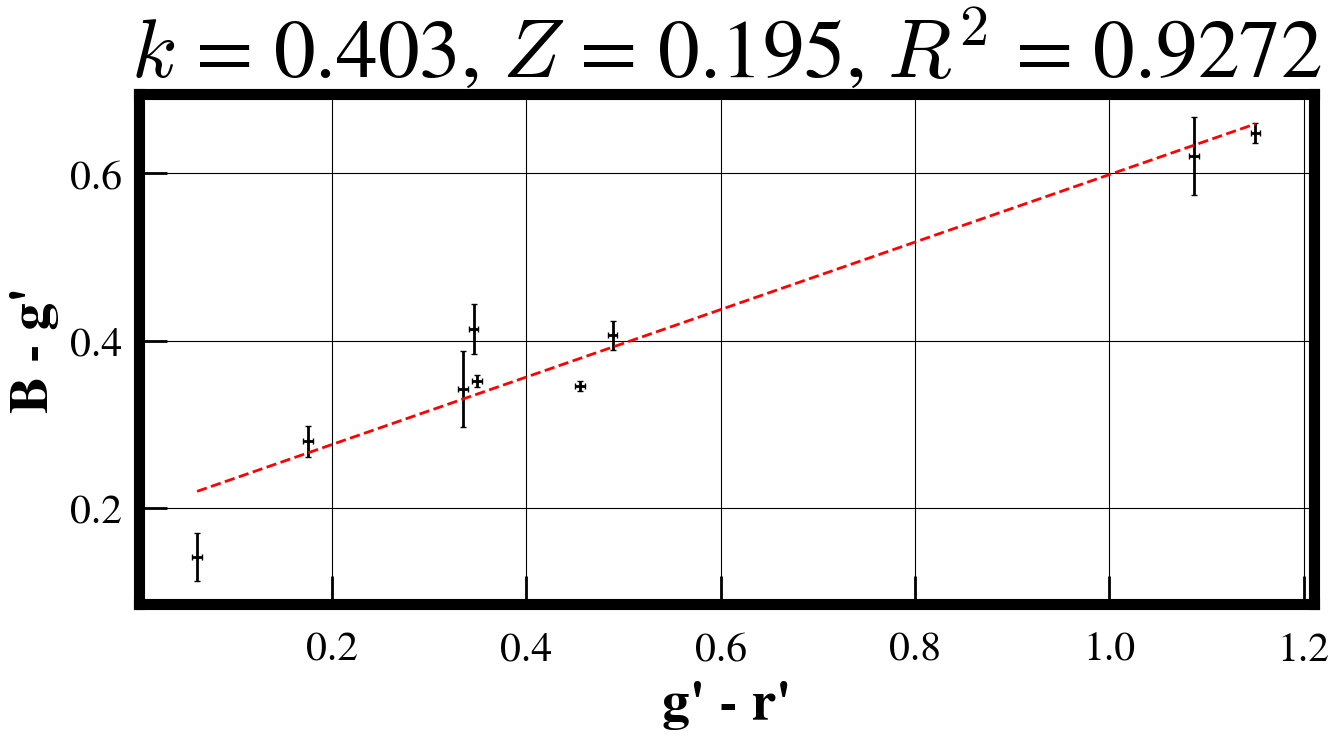

In [32]:
mag_y_1, band_y_1 = field_table['B-V'] + field_table['Vmag'], 'B'
err_y_1 = field_table['e_B-V']

mag_y_2, band_y_2 = field_table['modelMag_g'], 'g\''
err_y_2 = field_table['modelMagerr_g']

mag_x_1, band_x_1 = field_table['modelMag_g'], 'g\''
err_x_1 = field_table['modelMagerr_g']

mag_x_2, band_x_2 = field_table['modelMag_r'], 'r\''
err_x_2 = field_table['modelMagerr_r']

non_sat = field_table['non_saturated']
sep_arr = field_table['separation']
sep_lim = 5 * u.arcsec

plot_maker(mag_y_1, band_y_1, err_y_1, mag_y_2, band_y_2, err_y_2, 
           mag_x_1, band_x_1, err_x_1, mag_x_2, band_x_2, err_x_2, 
           non_sat, sep_arr, sep_lim)

plt.tight_layout()

plt.savefig(f'{field_name}_{band_y_1}_{band_y_2}_{band_x_1}_{band_x_2}.png')


### [Further study]

- Saturation이 일어난 대상을 포함하면 표준화가 잘 되지 않는다. 그 이유는?

- 하나의 field만 선택하여 표준화를 진행하였다. 이 일련의 과정을 통해 얻은 field_name.csv 여러개를 동시에 사용하여 표준화를 진행한다면?